In [29]:
import torch
import torch.nn as nn
from factory import convnext_factory
from torch.utils.data import DataLoader
from tqdm import tqdm

from datasets import create_imagenet_dataset
import torchvision
import torchvision.transforms as tvt
from torchvision.datasets import ImageNet
import itertools

import pandas as pd

In [25]:
def evaluate(testloader, model, image_xform=None):
    correct = 0
    total = 0
    model = model.eval()
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images = images.to("cuda")
            if image_xform:
                images = image_xform(images)
            labels = labels.to("cuda")

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [26]:
val_dataset = create_imagenet_dataset("val", data_dir="E:\datasets\imagenet", eval_transform=torchvision.models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1.transforms())
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4)

In [27]:
model, cfg = convnext_factory("convnext_tiny", weights=True)
model = model.to('cuda')

c:\Users\jajal\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Goal: Measure the effect of transforms on the quality of predictions, i.e., this is a proxy for I(Y; F).
## Subgoal: Measure the effect of transforms on the I(X;F), we proxy this with reconstruction loss.

# Experimental Setup

## Models
- convnext_tiny
- convnext_small
- convnext_base
- convnext_large

## Transforms
- Image Size
    - [32, 32]
    - [64, 64]
    - [96, 96]
    - [128, 128]
    - [160, 160]
    - [192, 192]
    - [224, 224]

## Measurements
- Test Accuracy

In [35]:
resize_sizes = range(224, 352 + 1, 32)
model_names = ["convnext_tiny", "convnext_small", "convnext_base", "convnext_large"]

data = {model_name: {} for model_name in model_names}
for resize_shape, model_name in itertools.product(resize_sizes, model_names):
    model, cfg = convnext_factory(model_name, weights=True)
    model = model.to('cuda')
    image_xform = tvt.Resize(resize_shape)
    accuracy = evaluate(val_dataloader, model, image_xform)
    data[model_name][resize_shape] = accuracy

c:\Users\jajal\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [01:16<00:00, 10.27it/s]
c:\Users\jajal\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 782/782 [01:46<00:00,  7.33it/s]
c:\Users\jajal\anaconda3\lib\site-packages\torchvision\models\_uti

In [52]:
data = torch.load("resize_convnext_experiment.pth")

In [53]:
data

{'convnext_tiny': {32: 0.11702,
  64: 0.49904,
  96: 0.70136,
  128: 0.7736,
  160: 0.80256,
  192: 0.81442,
  224: 0.82522,
  256: 0.81684,
  288: 0.81096,
  320: 0.80274,
  352: 0.78764},
 'convnext_small': {32: 0.14916,
  64: 0.5548,
  96: 0.7324,
  128: 0.79068,
  160: 0.81454,
  192: 0.82482,
  224: 0.83472,
  256: 0.82858,
  288: 0.82486,
  320: 0.81964,
  352: 0.80838},
 'convnext_base': {32: 0.15782,
  64: 0.57236,
  96: 0.74326,
  128: 0.79888,
  160: 0.82174,
  192: 0.82982,
  224: 0.8392,
  256: 0.83466,
  288: 0.83014,
  320: 0.82706,
  352: 0.81952},
 'convnext_large': {32: 0.17308,
  64: 0.59838,
  96: 0.75824,
  128: 0.80782,
  160: 0.8273,
  192: 0.83542,
  224: 0.8435,
  256: 0.8368,
  288: 0.83458,
  320: 0.82884,
  352: 0.8215}}

<Axes: >

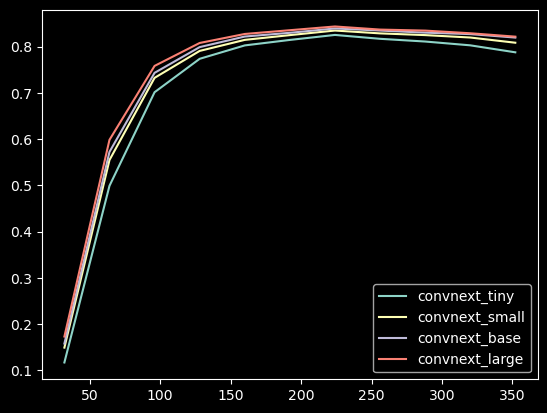

In [54]:
df = pd.DataFrame(data)
df.plot()